<h1> Live forehead temperature </h1>

In [ ]:
"""
# FLIR Thermal Face Detection Notebook

Features:
- Adjustable capture interval via --interval argument
- Face detection in visible images
- Temperature extraction from corresponding thermal ROIs
- Real-time visualization
"""
# %%
import os
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import cv2
from flir_image_extractor import FlirImageExtractor
from flir import Flir
from IPython.display import display, clear_output
import tempfile


scale_factor = 8
# %%
# Argument Parser Setup
def parse_args():
    parser = argparse.ArgumentParser(description='FLIR Thermal Face Detection')
    parser.add_argument('--interval', type=float, default=2.0,
                       help="Snapshot interval in seconds (default: 2.0)")
    parser.add_argument('--camera', type=str, default="http://192.168.0.10/",
                       help="FLIR camera URL")
    parser.add_argument('--exiftool', type=str, 
                       default="C:/Program Files (x86)/ExifTool/exiftool.exe",
                       help="Path to exiftool executable")
    return parser.parse_args([])  # Empty list for notebook, use None for script

args = parse_args()

# %%
class FlirThermalProcessor:
    def __init__(self, camera_url, exiftool_path):
        self.camera_url = camera_url
        self.exiftool_path = exiftool_path
        self.fie = FlirImageExtractor(exiftool_path=exiftool_path)
        
        # Initialize FLIR camera
        self.flir = Flir(baseURL=camera_url)
        self.flir.login()
        
        # Face detection model
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        
        # Create output directory if it doesn't exist
        self.output_dir = 'output'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def capture_images(self):
        """Capture visible and thermal images"""
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        
        # Configure camera
        self.flir.showOverlay(False)
        self.flir.setAutoTemperatureRange()
        
        # Capture visible image
        self.flir.setVisualMode()
        vis_path = os.path.join(self.output_dir, f"vis_{timestamp}.jpg")
        self.flir.getSnapshot(vis_path)
        vis_img = cv2.imread(vis_path)
        
        # Capture thermal image
        self.flir.setIRMode()
        thermal_path = os.path.join(self.output_dir, f"thermal_{timestamp}.jpg")
        self.flir.getSnapshot(thermal_path)
        
        return vis_img, thermal_path
    
    def process_thermal_image(self, thermal_path):
        """Extract temperature data from thermal image"""
        self.fie.process_image(thermal_path)
        return self.fie.get_thermal_np()
    
    def detect_faces(self, vis_img):
        """Detect faces in visible image"""
        gray = cv2.cvtColor(vis_img, cv2.COLOR_BGR2GRAY)
        return self.face_cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    def get_face_temperatures(self, faces, thermal_data):
        """Calculate temperature stats for each forehead region"""
        temp_stats = []
        for (x, y, w, h) in faces:
            # Define forehead region (upper middle part of the face)
            fx = x + int(w * 0.1)
            fw = int(w * 0.8)
            fy = y + int(h * 0.05)
            fh = int(h * 0.2)
            
            forehead_region = thermal_data[fy:fy+fh, fx:fx+fw]
            temp_stats.append({
                'max': np.max(forehead_region),
                'min': np.min(forehead_region),
                'mean': np.mean(forehead_region),
                'median': np.median(forehead_region),
                'face_roi': (x, y, w, h),
                'forehead_roi': (fx, fy, fw, fh),
                'face_roi_image': (scale_factor*x, scale_factor*y, scale_factor*w, scale_factor*h),
                'forehead_roi_image': (scale_factor*fx, scale_factor*fy, scale_factor*fw, scale_factor*fh)
            })
        return temp_stats
    
    def visualize_results(self, vis_img, thermal_data, temp_stats):
        """Display results with face and forehead annotations"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        vis_display = vis_img.copy()
        
        for i, stats in enumerate(temp_stats):
            # Draw face box
            x, y, w, h = stats['face_roi_image']
            cv2.rectangle(vis_display, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Draw forehead box
            fx, fy, fw, fh = stats['forehead_roi_image']
            cv2.rectangle(vis_display, (fx, fy), (fx+fw, fy+fh), (255, 0, 0), 2)

            text = f"Face {i+1}: {stats['mean']:.1f}°C"
            cv2.putText(vis_display, text, (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        ax1.imshow(cv2.cvtColor(vis_display, cv2.COLOR_BGR2RGB))
        ax1.set_title('Visible Image (Face & Forehead)')
        ax1.axis('off')

        # Normalize thermal data for display
        thermal_normalized = (thermal_data - thermal_data.min()) / (thermal_data.max() - thermal_data.min())
        thermal_colored = plt.cm.hot(thermal_normalized)

        ax2.imshow(thermal_colored)
        ax2.set_title('Thermal Image (Forehead ROI)')
        ax2.axis('off')

        for stats in temp_stats:
            fx, fy, fw, fh = stats['forehead_roi']
            rect = plt.Rectangle((fx, fy), fw, fh, linewidth=2, edgecolor='lime', facecolor='none')
            ax2.add_patch(rect)
            ax2.text(fx, fy - 5, f"{stats['mean']:.1f}°C", color='lime', fontsize=10)

        plt.tight_layout()
        plt.show()

# %%
# Initialize processor
processor = FlirThermalProcessor(
    camera_url=args.camera,
    exiftool_path=args.exiftool
)

# %%
# Main processing loop
try:
    while True:
        start_time = time.time()
        
        # Capture and process images
        vis_img, thermal_path = processor.capture_images()
        thermal_data = processor.process_thermal_image(thermal_path)

        faces = processor.detect_faces(vis_img)
        
        # Get temperatures if faces found
        temp_stats = processor.get_face_temperatures((faces/scale_factor).astype(int), thermal_data) if len(faces) > 0 else []
        
        # Visualize results
        processor.visualize_results(vis_img, thermal_data, temp_stats)
        
        # Clean up
        os.remove(thermal_path)
        os.remove(thermal_path.replace('thermal_', 'vis_'))
        
        # Wait for next capture
        #elapsed = time.time() - start_time
        #sleep_time = max(0, args.interval - elapsed)
        #time.sleep(sleep_time)
        time.sleep(2)
        clear_output(wait=True)

except KeyboardInterrupt:
    print("Processing stopped by user")
except Exception as e:
    print(f"Error: {str(e)}")

Getting image from camera


<h1> Forehaed temperature estimation PRINT </h1>

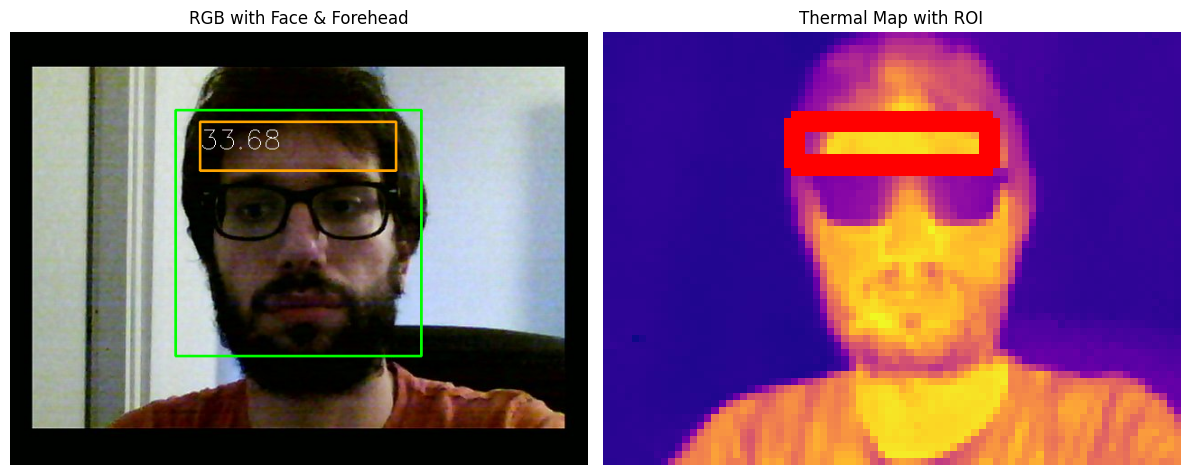

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load RGB image
image_path = 'image.jpg'
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Load corresponding thermal map
thermal_path = 'thermal_map.npy'
thermal = np.load(thermal_path) 

# Face detection
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

# Copy for drawing
rgb_vis = img_rgb.copy()
thermal_vis = cv2.normalize(thermal, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
thermal_vis_color = cv2.applyColorMap(thermal_vis, cv2.COLORMAP_PLASMA)

# Process first detected face
for (x, y, w, h) in faces[:1]:

    # Forehead
    fy = y + int(h * 0.05)
    fh = int(h * 0.2)
    fx = x + int(w * 0.1)
    fw = int(w * 0.8)

    # ROI: 1/8 of forehead
    roi_w = fw // 8
    roi_h = fh // 8
    roi_x = fx // 8
    roi_y = fy // 8

    # Draw rectangles on RGB image
    cv2.rectangle(rgb_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)         # face
    cv2.rectangle(rgb_vis, (fx, fy), (fx+fw, fy+fh), (255, 165, 0), 2) # forehead

    # Draw rectangles on thermal image
    cv2.rectangle(thermal_vis_color, (roi_x, roi_y), (roi_x+roi_w, roi_y+roi_h), (0, 0, 255), 2)

    # Compute average
    #avg_temp = np.mean(thermal[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w])
    avg_temp = np.median(thermal[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w])
    cv2.putText(rgb_vis, f"{avg_temp:.2f}", (fx, fy+30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1)

# Plot side-by-side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_vis)
plt.title('RGB with Face & Forehead')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(thermal_vis_color, cv2.COLOR_BGR2RGB))
plt.title('Thermal Map with ROI')
plt.axis('off')

plt.tight_layout()
plt.show()
